In [1]:
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer
import numpy as np

# initialize configuration parameters for a specific experiment
experiment = 'ex10'
initialize(config_path=f"../config/{experiment}")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")
def generate_sliding_windows(volume_dimension, window_size=2):
    """
    Generates coordinates for sliding windows in a 3D cubic volume.
    Args:
    - volume_dimension: The size of the cubic volume
    - window_size: The size of the sliding window (default is 2 for a 2x2x2 window)
    Returns:
    - A list of lists, where each inner list contains tuples of (i, j, k) coordinates
      for all points within a window.
    """

    windows = []

    # Traverse the 3D volume
    for i in range(volume_dimension - window_size + 1):
        for j in range(volume_dimension - window_size + 1):
            for k in range(volume_dimension - window_size + 1):
                # Initialize the current window's list of coordinates
                current_window = []
                
                # Populate the current window with coordinates
                for di in range(window_size):
                    for dj in range(window_size):
                        for dk in range(window_size):
                            current_window.append((i+di, j+dj, k+dk))
                
                # Add the current window's coordinates to the main list
                windows.append(current_window)

    return windows


def expand_cond_single(cond_base):
     features_num = 27
     cond_flatten = cond_base.unsqueeze(0).expand(features_num, -1)
     return cond_flatten.unsqueeze(0).float()


def init_ds_spatial_info(volume_dimension):
    ds = {}
    for i in range(volume_dimension):
        for j in range(volume_dimension):
            for k in range(volume_dimension):
                # store spatial info
                ds[(i, j, k)] = {}
                phi_gen = torch.rand(1) * (phi_large - phi_small) + phi_small
                ds[(i, j, k)]['phi'] = phi_gen.item()
                ds[(i, j, k)]['token'] = None
                ds[(i, j, k)]['z'] = None
                ds[(i, j, k)]['cond'] = None
                ds[(i, j, k)]['img'] = None
    return ds



def add_noise_to_cond(cond,device):
    b,seq_len,_ = cond.shape
    noise = torch.randn(b, seq_len, 1).to(device)
    cond = torch.cat([cond, noise], dim=-1)
    return cond

def mean_squared_error(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("The lists must have the same length.")
    
    squared_errors = [(x - y) ** 2 for x, y in zip(list1, list2)]
    mse = sum(squared_errors) / len(list1)
    return mse

def gen_img_from_z(z):
    with torch.no_grad():
        img = model_vqgan.decode(z)
        img = img_prc.clean_img(img)[0]
    return img

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [4]:
epoch_vqgan = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)
vqgan_path = os.path.join(root_path,f'vqgan_epoch_{epoch_vqgan}.pth')
model_vqgan = vqgan.VQGAN(cfg_vqgan)
model_vqgan.load_checkpoint(vqgan_path)
model_vqgan = model_vqgan.to(device)
model_vqgan.eval()


eval_dict = {}
eval_dict['epoch'] = [x for x in range(90,235,5)]
eval_dict['mse'] = []

for epoch_transformer in eval_dict['epoch']:
    
    transformer_path = os.path.join(
        root_path,
        'transformer',
        f'transformer_epoch_{epoch_transformer}.pth'
        )
    model_transformer = transformer.Transformer(cfg_transformer)
    model_transformer.load_checkpoint(transformer_path)
    model_transformer = model_transformer.to(device)
    model_transformer.eval()

    # some defulat parameters
    large_img_size = 10
    sub_img_size = 2
    phi_large = 0.4
    phi_small = 0.05


    from cpgan.ooppnm import img_process
    img_prc = img_process.Image_process()





    windows_idx = generate_sliding_windows(large_img_size)
    ds_spatial = init_ds_spatial_info(large_img_size)

    sos_token = 3000
    top_k = 2
    features_num = 27

    phi = ds_spatial[(0,0,0)]['phi']
    cond_vec = torch.tensor([phi, 0, 0, 0]).to(device)
    cond_vec = expand_cond_single(cond_vec)
    # cond_vec = add_noise_to_cond(cond_vec,device)

    sos_tokens = torch.ones(1, features_num) * sos_token
    sos_tokens = sos_tokens.long().to(device)
    token_nxt = model_transformer.model.sample(sos_tokens, cond_vec,top_k=top_k)
    z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=features_num)

    ds_spatial[(0,0,0)]['cond'] = cond_vec
    ds_spatial[(0,0,0)]['z'] = z_current
    ds_spatial[(0,0,0)]['token'] = token_nxt
    ds_spatial[(0,0,0)]['img'] = gen_img_from_z(z_current)

    # filling in z in attention window


    for slide_window_idx in windows_idx:
        flat_idx = 0
        # initialize aggregated vector in each window
        cond_window = []
        token_list = [sos_tokens]
        # create normalized ijk condition vector
        for i in range(sub_img_size):
            for j in range(sub_img_size):
                for k in range(sub_img_size):
                    # get absolute
                    abs_ijk = slide_window_idx[flat_idx]
                    

                    if ds_spatial[abs_ijk]['token'] is not None:
                        cond_vec = ds_spatial[abs_ijk]['cond'].clone()
                        token_current = ds_spatial[abs_ijk]['token'].clone()
                        cond_window.append(cond_vec)
                        token_list.append(token_current)
                        flat_idx += 1
                        continue # no need for inference
                    
                    phi = ds_spatial[abs_ijk]['phi']
                    # generate conditional informatino
                    cond_vec = torch.tensor([phi, i, j, k]).to(device)
                    cond_vec = expand_cond_single(cond_vec)
                    # cond_vec = add_noise_to_cond(cond_vec,device)
                    cond_window.append(cond_vec)
                    cond_input = torch.cat(cond_window, dim=1)

                    # aggregate previous tokens
                    token_input = torch.cat(token_list, dim=1)
                    token_nxt = model_transformer.model.sample(token_input, cond_input,top_k=top_k)
                    token_list.append(token_nxt)

                    # update spatial ds
                    ds_spatial[abs_ijk]['token'] = token_nxt
                    ds_spatial[abs_ijk]['cond'] = cond_vec
                    z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=features_num)
                    ds_spatial[abs_ijk]['z'] = z_current
                    ds_spatial[abs_ijk]['img'] = gen_img_from_z(z_current)
                    
                    flat_idx += 1



    def get_volume_shape(ds_spatial):
        max_i, max_j, max_k = 0, 0, 0
        for ijk in ds_spatial.keys():
            i, j, k = ijk
            max_i = max(max_i, i)
            max_j = max(max_j, j)
            max_k = max(max_k, k)
        return max_i + 1, max_j + 1, max_k + 1

    def assemble_volume(ds_spatial):
        volume_shape = get_volume_shape(ds_spatial)
        volume = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))

        for ijk, data in ds_spatial.items():
            i, j, k = ijk
            image = data['img']
            volume[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image[0]

        return volume

    volume = assemble_volume(ds_spatial)
    # plt.imshow(volume[0], cmap='gray')

    phi_list = []
    phi_gen_list = []

    for keys in ds_spatial.keys():
        phi_list.append(ds_spatial[keys]['phi'])
        img = ds_spatial[keys]['img']
        phi_gen = img_prc.phi(img)
        phi_gen_list.append(phi_gen)



    err = mean_squared_error(phi_list, phi_gen_list)
    eval_dict['mse'].append(err)

number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M
number of parameters: 183.94M


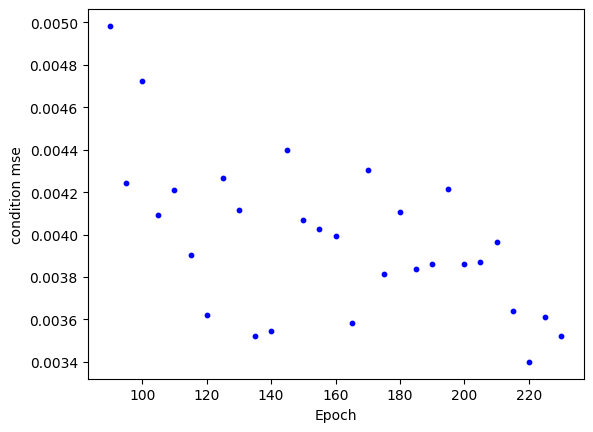

In [8]:
f = plt.figure()
plt.scatter(eval_dict['epoch'], eval_dict['mse'],s=10,c='b')
# plt.plot([0,0.6],[0,0.6],c='r')
# plt.xlim([0,0.5])
# plt.ylim([0,0.5])
plt.xlabel('Epoch')
plt.ylabel('condition mse')
plt.show()

In [6]:
eval_dict['mse']

[0.004983866862440282,
 0.004241187974614544,
 0.00472556682987033,
 0.0040946460378709255,
 0.00420826920118405,
 0.003906251843364787,
 0.0036224664627395146,
 0.00426922060077219,
 0.004116522619947228,
 0.0035233304671842005,
 0.003545101347935526,
 0.0044009028188775265,
 0.00406747025748979,
 0.0040259789389910025,
 0.0039945019831706,
 0.0035850460236417528,
 0.004307031437263408,
 0.003812592227001858,
 0.004104967324561236,
 0.003836437428863593,
 0.0038614501129886577,
 0.004216103169721515,
 0.003860060429465851,
 0.003870511380262558,
 0.0039636893526730265,
 0.0036422887802711524,
 0.0033999550758278922,
 0.003612373042634516,
 0.0035204317262642606]

In [7]:
eval_dict['epoch']

[90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230]